# WOS 批量论文自动化分析

In [15]:
import os
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import collections

## 1 数据预处理模块

### 1.1 数据清洗

In [16]:
import data_clean
inputFile1 = 'savedrecs.xls'
outputFile1 = data_clean.coreDataSelect(inputFile1)

### 1.2 检查清洗数据

In [17]:
df = pd.read_excel(outputFile1)
df.columns

Index(['原文标题', '期刊', '作者关键词', 'WOS 关键词', '摘要', '作者地址', '机构', '引用次数', '发表年份',
       'DOI', '研究领域'],
      dtype='object')

## 2 关键词信息可视化模块

### 2.1 合并关键词列并大写化

In [18]:
# 将所有关键词合并成列表并全部首字母大写化
def all_keywords(inputFile):
    df = pd.read_excel(inputFile)
    # 以分号合并两列关键词内容，并以分号切割成列表，需要注意的是 "; " 而不是 ";"
    keywords = df["作者关键词"].str.cat(sep="; ") + df["WOS 关键词"].str.cat(sep="; ")
    word_list = keywords.split("; ")
    # 使用列表推导式和 str.title () 方法将列表中的字符串全部转换为首字母大写
    # str.upper () 全体大写
    word_list_upper = [w.title() for w in word_list]
    return word_list_upper

### 2.2 关键词同义合并

In [19]:
# 关键词同义合并，并返回合并后的单词列表
def synonymMerge(inputFile):
    word_list = all_keywords(inputFile)
    # 读取映射表
    df = pd.read_excel("../data/input/related_terms.xlsx")
    mapping_dict = dict(zip(df["Original_Word"], df["Mapping_Word"]))
    # 创建一个空列表用于存储转化后的元素
    transformed_list = []
    # 遍历word_list列表中的每个元素
    for word in word_list:
        # 如果元素在字典中有对应的键，则用字典中的值替换它，否则保持不变
        new_word = mapping_dict.get(word, word)
        # 将转化后的元素添加到新列表中
        transformed_list.append(new_word)    
    # 返回合并后的列表类型的数据
    return transformed_list

### 2.3 关键词词频统计

In [20]:
def wordCount(inputFile, outputFile):
    # 同义词替换
    word_list = synonymMerge(inputFile)
    # 使用collections进行词频统计，获取前300个高频词及其出现次数
    # 返回一个字典，键为分词，值为出现次数
    word_counts = collections.Counter(word_list)
    # 返回一个列表，每个元素是一个元组，包含分词和出现次数
    word_counts_top300 = word_counts.most_common(300)
    # 将词频统计的结果导出成新的excel文档
    # 创建一个数据框存放列表数据
    df_word_counts = pd.DataFrame(word_counts_top300, columns=["Keyword", "Count"])
    # 导出数据到excel文件，并去掉索引列
    df_word_counts.to_excel(outputFile, index=False)

In [21]:
inputFile2 = outputFile1
outputFile2 = "../data/output/keyword_counts.xlsx"
wordCount(inputFile2, outputFile2)

### 2.4 关键词词云绘制

In [22]:
from wordcloud import WordCloud, STOPWORDS

In [23]:
# 创建和保存词云图像
def create_wordcloud(word_freq, font_path, output_file):
    wc = WordCloud(
        # width = 300,
        # height = 200,
        background_color = 'white', 
        prefer_horizontal = 1, 
        min_font_size = 2,
        max_font_size = 32,
        font_path = f'../data/fonts/{font_path}', # 使用 f-string 格式化字符串
        scale = 4,
        max_words = 300
        # stopwords = STOPWORDS, # 直接传入停用词集合
        # colormap = 'viridis' # 指定颜色映射
    ).generate_from_frequencies(word_freq)
    plt.figure(figsize=(6,6), dpi=300)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wc.to_file(f'../data/output/{output_file}')

In [24]:
# 关键词词云
def keywordCloud(inputFile, lang='en'):
    # 读取 xlsx 文件中的数据
    df = pd.read_excel(inputFile)
    # 将数据转换成字典，键为关键词，值为频数
    word_freq = dict(zip(
        df['Keyword' if lang == 'en' else 'Keyword_Translation'],
        df['Count']
    ))
    # 调用函数，生成英文/中文的词云图像
    wc = create_wordcloud(
        word_freq,
        'times.ttf' if lang == 'en' else 'simsun.ttc',
        f'wordcloud_{lang}.png'
    )

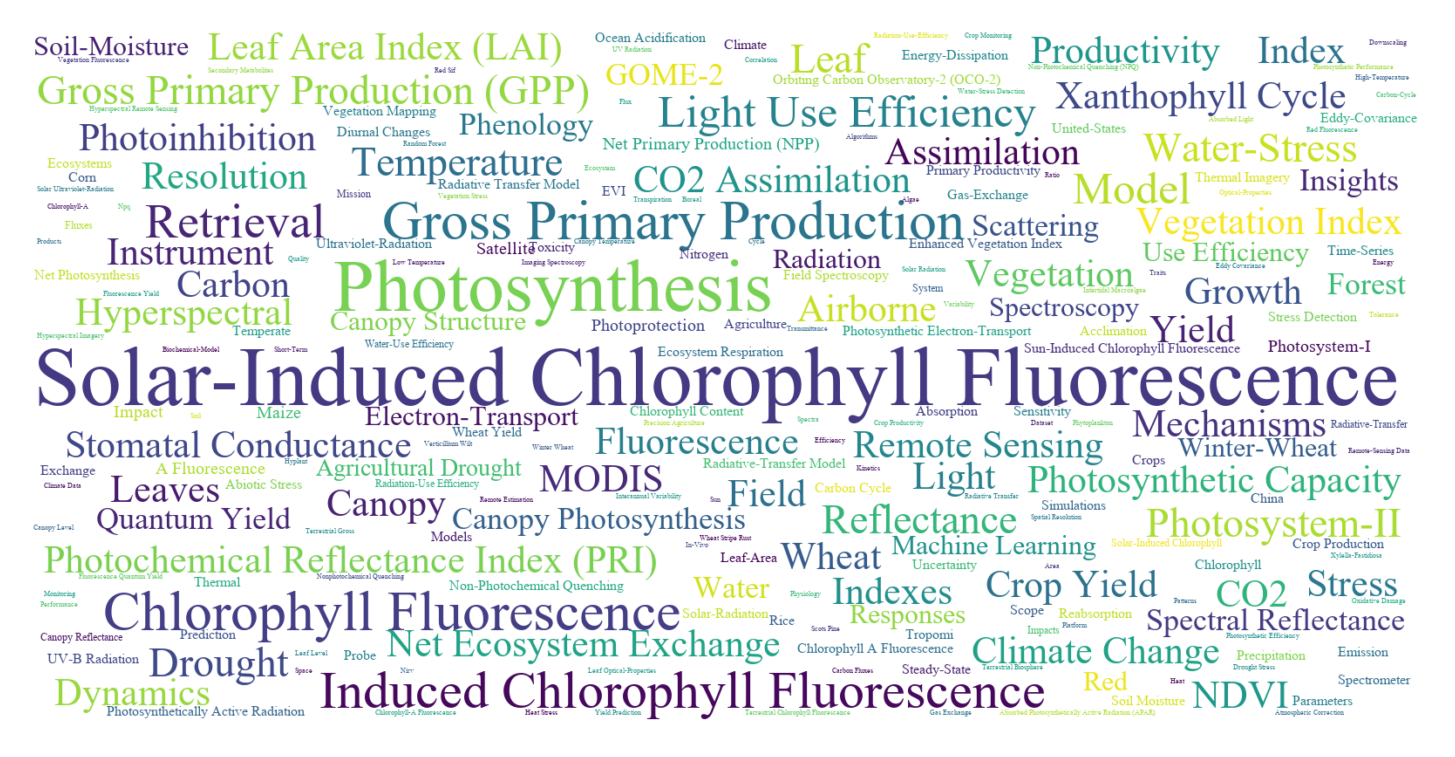

In [25]:
inputFile3 = outputFile2
keywordCloud(inputFile3)

## 3 翻译模块

In [26]:
# 批量翻译
def keywords_tranlate(source_file, source_column, target_file, target_column):
    import tencent_translate
    tencent_translate.write_results(source_file, source_column, target_file, target_column)

In [27]:
# source_file = outputFile2
# target_file = "../data/output/test_tranlate_counts.xlsx"
# keywords_tranlate(source_file, "原文标题", target_file, "标题翻译")

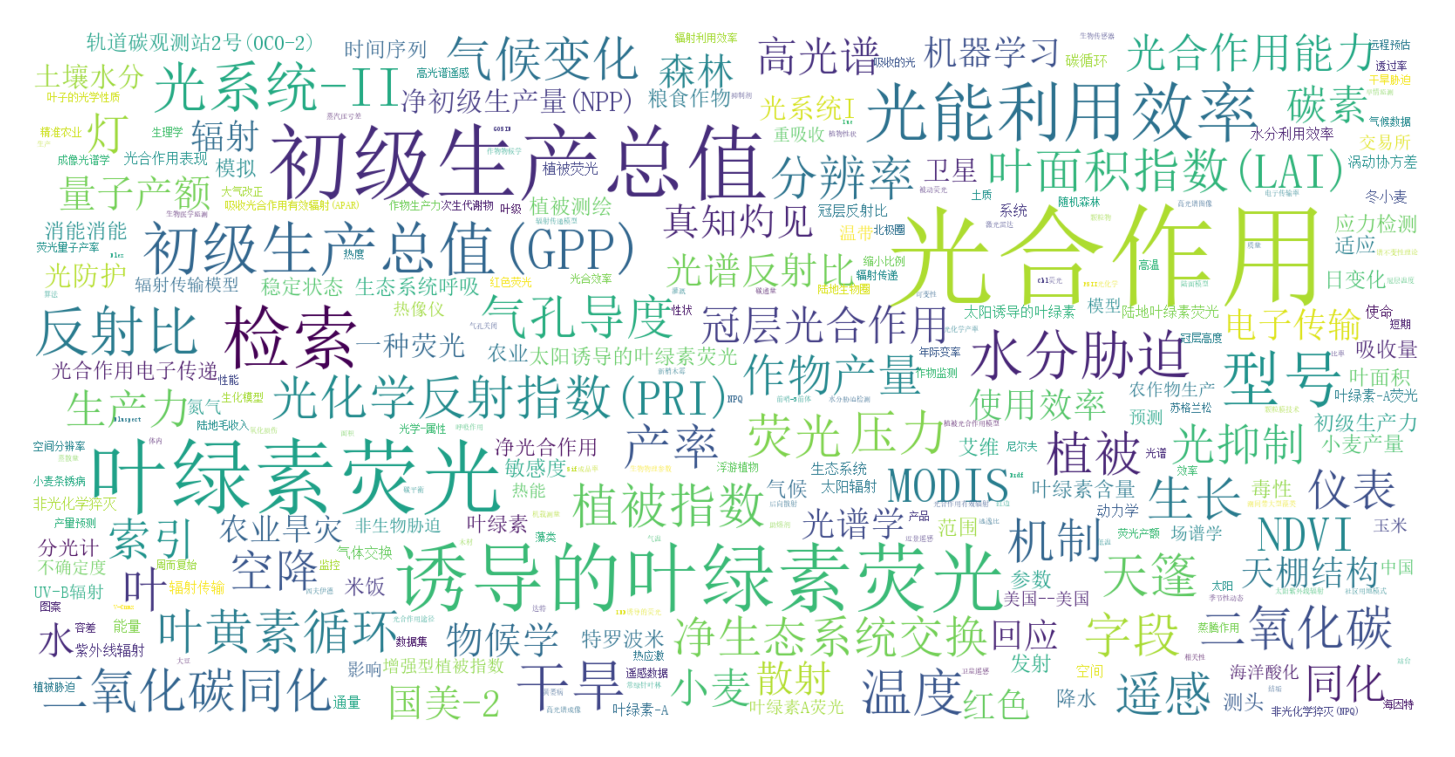

In [28]:
inputFile3 = outputFile2
outputFile3 = "../data/output/keyword_tranlate_counts.xlsx"
keywords_tranlate(inputFile3, "Keyword", outputFile3, "Keyword_Translation")
keywordCloud(outputFile3, lang='zh')